In [26]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from hopkins import Hopkins
from tqdm import tqdm


In [27]:
# 获取当前脚本文件所在目录的绝对路径
current_dir = os.getcwd()
# 构造 "data" 目录的路径
data_dir = os.path.join(current_dir, "../data")  # 返回上一级目录下的 "data" 目录
# 定义文件名
file_name = f"Sample20240514144405.txt"
file_path = os.path.join(data_dir, file_name)

In [28]:
# 读取文本文件
with open(file_path, 'r') as file:
    lines = file.readlines()

# 解析每行数据
data = []
for line in lines:
    row = list(map(float, line.strip().split()))
    data.append(row)

# 将数据转换为 NumPy 数组
import numpy as np
data_array = np.array(data)

print("Data shape:", data_array.shape)
print("Sample of data:")
print(data_array[:5])  # 打印前5行数据

Data shape: (3000, 14)
Sample of data:
[[7.63816506e+01 1.64317419e+02 1.60903408e+03 2.35803808e+02
  6.99423243e+02 8.60717217e-01 4.35726617e+01 1.36218394e+04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [7.53652094e+01 1.70428040e+02 2.22969946e+03 2.65409852e+02
  8.54781429e+02 7.10429807e-01 1.28680063e+01 1.40067796e+04
  1.00000000e+00 1.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [5.74220388e+01 1.86899009e+02 2.78777861e+03 2.31782684e+02
  9.60511218e+02 5.97251591e-01 1.11501596e+01 1.35783834e+04
  0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [5.50701111e+01 1.56606523e+02 3.05552458e+03 2.05867305e+02
  6.12825018e+02 1.24793853e+00 9.73099231e+00 1.44471962e+04
  1.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [8.35964001e+01 1.76896161e+02 2.03434992e+03 2.19550668e+02
  1.12993206e+03 1.2133

In [29]:
labels = data_array[:, -2:].tolist()  # 提取最后两列作为标签，并转换为列表
# 创建字典来存储数据分组
grouped_data = {}

In [30]:
for i, label in enumerate(labels):
    label_key = tuple(label)
    if label_key not in grouped_data:
        grouped_data[label_key] = []
    grouped_data[label_key].append(data_array[i, :-2])  # 去除最后两列
# 打印每个分组中的数据数量
for label, group in grouped_data.items():
    print(f"Label {label}: {len(group)} samples")

Label (1.0, 1.0): 600 samples
Label (14.0, 1.0): 800 samples
Label (30.0, 0.0): 400 samples
Label (33.0, 0.0): 200 samples
Label (0.0, 0.0): 200 samples
Label (1.0, 0.0): 800 samples


In [31]:
for label, group in grouped_data.items():
    grouped_data[label] = np.array(group)

In [32]:
target_label = (14.0, 1.0)
if target_label in grouped_data:
    cluster_data = grouped_data[target_label]
    Hopkins_value = Hopkins(cluster_data)
    print(Hopkins_value)
else:
    Hopkins_value = 0.0

Hopkins: 100%|██████████| 80/80 [00:00<00:00, 2480.39it/s]

0.9208179660720192


In [33]:
from HybridClustering import hybrid_clustering
if(Hopkins_value>0.55):
    kmeans_labels = hybrid_clustering(grouped_data[target_label],2,6)
    from WriteCluster import write_cluster_data, write_dbscan_cluster_data
    write_cluster_data(grouped_data[target_label], kmeans_labels, "kmeans")

from boundaries import extract_boundaries
upper_bounds, lower_bounds = extract_boundaries('cluster_0_kmeans.txt')
print("\n")
print("kmeans Upper boundaries:", upper_bounds)
print("kmeans Lower boundaries:", lower_bounds)


 Best number of clusters: 4


writing: 100%|██████████| 4/4 [00:00<00:00, 717.10it/s]
boundary: 199it [00:00, 199680.98it/s]



kmeans Upper boundaries: [21.304753331767337, 171.5220988650607, 3170.228346105051, 305.4489560295191, 4641.457460955288, 1.1831720170370494, 171.80097872774445, 6417.702536993428, 1.0, 1.0, 1.0, 1.0]
kmeans Lower boundaries: [-26.854622159574067, 116.81752294429697, 414.6234622274769, 213.118437295211, 3137.40837652266, -0.2237605470826256, 61.84700100854365, 1597.7671603709111, 0.0, 0.0, 0.0, 0.0]


TSNE: 100%|██████████| 100/100 [00:01<00:00, 53.92it/s]


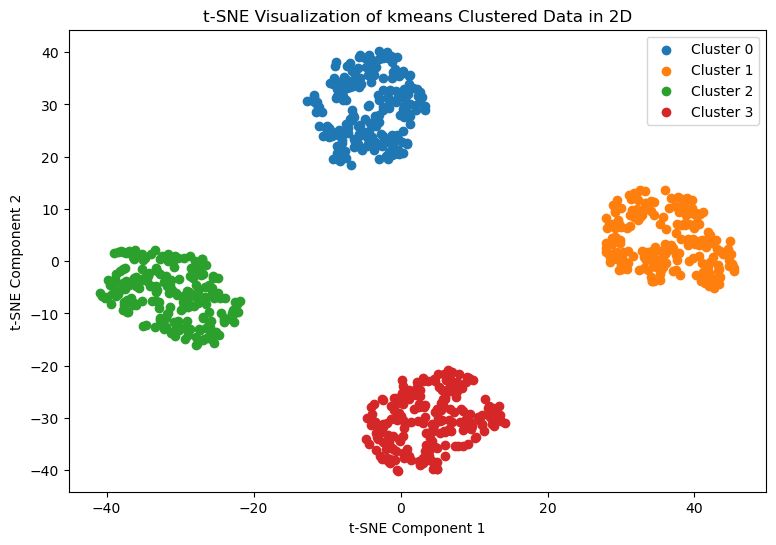

In [34]:
# 使用 t-SNE 进行降维，将数据投影到二维空间
tsne = TSNE(n_components=2, random_state=42)
with tqdm(total=100, desc="TSNE") as pbar:
    X_embedded = tsne.fit_transform(cluster_data)
    pbar.update(100)

# 绘制聚类结果的二维散点图
plt.figure(figsize=(9, 6))

# 绘制每个簇的数据点
for cluster_label in np.unique(kmeans_labels):
    visual_data = X_embedded[kmeans_labels == cluster_label]
    plt.scatter(visual_data[:, 0], visual_data[:, 1], label=f'Cluster {cluster_label}')

plt.title('t-SNE Visualization of kmeans Clustered Data in 2D')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()